In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.v2.functional as F_v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Deep_Learning.Representation_Learning.Methods.AugPC.train import train as train_augpc
from Deep_Learning.Representation_Learning.Methods.AugPC.model import AugPC
from Deep_Learning.Representation_Learning.Methods.LAugPC.train import train as train_laugpc
from Deep_Learning.Representation_Learning.Methods.LAugPC.model import LAugPC
from Deep_Learning.Representation_Learning.Methods.HAugPC.train import train as train_haugpc
from Deep_Learning.Representation_Learning.Methods.HAugPC.model import HAugPC
from Deep_Learning.Representation_Learning.Methods.BYOL.train import train as train_byol
from Deep_Learning.Representation_Learning.Methods.BYOL.model import BYOL
from Deep_Learning.Representation_Learning.Methods.SimCLR.train import train as train_simclr
from Deep_Learning.Representation_Learning.Methods.SimCLR.model import SimCLR

from Deep_Learning.Representation_Learning.Examples.MNIST.mnist_linear_1k import mnist_linear_1k_eval

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])
augmentation = transforms.Compose([
    # transforms.RandomCrop(20),
    # transforms.Resize(28, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomAffine(degrees=180, translate=(0.28, 0.28), scale=(0.75, 1.25), shear=25),
    # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)


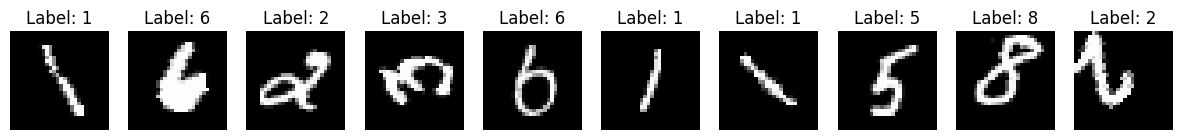

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [4]:
# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
    translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
    shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
    img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [5]:
Model = AugPC
backbone = 'alexnet'
model_name = f'{Model.__name__}-{backbone}'
log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{model_name}/'
save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{model_name}.pth'
# log_dir = None
# save_dir = None
model = Model(1, 5, backbone=backbone).to(device)

In [6]:
to_train = True
if save_dir is not None:
    try:
        sd = torch.load(save_dir)
        # change keys "project" to "transition"
        for key in list(sd.keys()):
            if 'project' in key:
                sd[key.replace('project', 'transition')] = sd.pop(key)
        model.load_state_dict(sd)
        to_train = False
        print('Model loaded successfully')
    except FileNotFoundError:
        pass
        print('Model not found, training new model')
if to_train:
    writer = None
    if log_dir is not None:
        writer = SummaryWriter(log_dir)
    # train_augpc(
    #     model,
    #     train_set,
    #     val_set,
    #     num_epochs=500,
    #     batch_size=128,
    #     lr=3e-4,
    #     wd=1.5e-6,
    #     writer=writer,
    #     save_dir=save_dir,
    #     save_every=5,
    #     aug_scaler='none'
    # )

    # train_laugpc(
    #     model,
    #     train_set,
    #     val_set,
    #     num_epochs=500,
    #     batch_size=256,
    #     lr=0.0001,
    #     wd=1.5e-6,
    #     beta=0.05,
    #     tau_0=0.925,
    #     tau_e=0.95,
    #     tau_T=100,
    #     aug_scaler='none',
    #     learn_on_ss=False,
    #     writer=writer,
    #     save_dir=save_dir,
    #     save_every=5,
    # )

    train_haugpc(
        model,
        train_set,
        val_set,
        num_epochs=500,
        batch_size=256,
        lr=0.000001,
        wd=1.5e-6,
        aug_scaler='none',
        learn_on_ss=False,
        normalise=False,
        writer=writer,
        save_dir=save_dir,
        save_every=5,
    )


    # train_byol(
    #     model,
    #     train_set,
    #     val_set,
    #     num_epochs=500,
    #     batch_size=256,
    #     lr=0.001,
    #     wd=1.5e-6,
    #     augmentation=augmentation,
    #     beta=None,
    #     tau_0=0.996,
    #     tau_e=0.999,
    #     tau_T=100,
    #     normalise=True,
    #     learn_on_ss=False,
    #     writer=writer,
    #     save_dir=save_dir,
    #     save_every=5,
    # )

    # train_simclr(
    #     model,
    #     train_set,
    #     val_set,
    #     num_epochs=500,
    #     batch_size=256,
    #     lr=3e-4,
    #     wd=0.0,
    #     temperature=1.0,
    #     augmentation=augmentation,
    #     writer=writer,
    #     save_dir=save_dir,
    #     save_every=5,
    # )

    print(f'Finished training')
    if save_dir is not None:
        print('Run cell again to load best (val_acc) model.')

Model loaded successfully


In [7]:
# collect 100 of each target index from train_set.targets
writer = SummaryWriter(log_dir)
mnist_linear_1k_eval(model, writer, flatten=True)

  0%|          | 0/60000 [00:00<?, ?it/s]

Best validation accuracy: 0.7276999354362488


In [7]:
img = train_set[4][0].unsqueeze(0)
model.eval()

def compare(model, img, angle, translate_x, translate_y, scale, shear):
    img_aug = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
    img_pred = model.predict(img, action)
    loss = F.mse_loss(img_aug, img_pred)
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(img_aug.squeeze().cpu(), cmap='gray')
    axes[1].set_title('Augmented')
    axes[1].axis('off')
    axes[2].imshow(img_pred.squeeze().cpu().detach(), cmap='gray')
    axes[2].set_title('Predicted')
    axes[2].axis('off')
    plt.show()
    return loss.item()

interact(compare, model=fixed(model), img=fixed(img), angle=(-180, 180), translate_x=(-8, 8), translate_y=(-8, 8), scale=(0.75, 1.25), shear=(-25, 25))

interactive(children=(IntSlider(value=0, description='angle', max=180, min=-180), IntSlider(value=0, descripti…

<function __main__.compare(model, img, angle, translate_x, translate_y, scale, shear)>